# **Test de grabación y transcripción de audio**

Este notebook usa las funciones de `utils_audio.py` para:
1. Grabar audio desde el micrófono (usando `sounddevice`).
2. Preprocesar el audio.
3. Transcribir con Whisper.

Si la grabación no es posible en el entorno, cargará archivos `.wav` de la carpeta `audio/`.

---
### **Librerías**

In [59]:
# Importar utilidades de audio
from utils_audio import load_whisper_model, preprocess_audio_file, transcribe_audio_file
import sounddevice as sd
import numpy as np
import tempfile, os
from scipy.io.wavfile import write
from IPython.display import Audio
import soundfile as sf
import torch
import librosa

# Ignorar los warnings 
import warnings
warnings.filterwarnings("ignore")

---
### **1. Grabar audio desde el micrófono**

In [60]:
def grabar_audio(clase: str, base_dir: str = 'data/outputs/6_audios', fs: int = 16000, duration: int = 5):
    """
    Graba audio desde el micrófono y lo guarda en una carpeta específica con nombres iterativos.

    Args:
        clase (str): Subcarpeta dentro de `base_dir` donde se guardará el audio.
        base_dir (str): Carpeta base donde se almacenarán los audios. Por defecto es 'data/outputs/6_audios'.
        fs (int): Frecuencia de muestreo. Por defecto es 16000 Hz.
        duration (int): Duración de la grabación en segundos. Por defecto es 5 segundos.
    """
    # Crear la carpeta si no existe
    output_dir = os.path.join(base_dir, clase)
    os.makedirs(output_dir, exist_ok=True)

    # Determinar el nombre del archivo iterativo
    existing_files = [f for f in os.listdir(output_dir) if f.lower().endswith('.wav')]
    next_index = len(existing_files) + 1
    audio_filename = f'audio_{next_index}.wav'
    audio_path = os.path.join(output_dir, audio_filename)

    print(f'Grabando {duration}s de audio a {fs}Hz en {audio_path}...')

    # Grabar audio
    try:
        recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
        sd.wait()  # Esperar a que termine
        print('Grabación completada')
        
        # Guardar a WAV en la carpeta especificada
        write(audio_path, fs, np.squeeze(recording))
        display(Audio(audio_path, rate=fs))
        return audio_path
    except Exception as e:
        print('No fue posible grabar:', e)
        
        # Fallback: tomar primer archivo de carpeta 'audio'
        files = [f for f in os.listdir('audio') if f.lower().endswith('.wav')]
        if files:
            fallback_path = os.path.join('audio', files[0])
            print('Usando archivo de prueba:', fallback_path)
            display(Audio(fallback_path))
            return fallback_path
        else:
            raise RuntimeError('No hay forma de obtener audio')

In [62]:
# grabamos un audio de prueba
# administracion, efectos_secundarios, otros
grabar_audio('', base_dir='audio', fs=16000, duration=5)

Grabando 5s de audio a 16000Hz en audio\audio_1.wav...
Grabación completada


'audio\\audio_1.wav'

---
### **2. Preprocesar y transcribir**

In [3]:
# Modelos disponibles en Whisper 
available_models = ["tiny", "base", "small", "medium", "large"]

# Pedir al ususario el modelo a usar
#model_size = input(f"¿Qué modelo usar? ({', '.join(available_models)}): ").strip().lower()
model_size = "medium" # mejor este de momento

In [4]:
# Cargar modelo Whisper (si no está ya cargado)
model, device = load_whisper_model(model_size)

# Preprocesar archivo
proc_path = preprocess_audio_file(audio_path, target_sr=16000)
print('Archivo preprocesado en:', proc_path)

# Función para transcribir un array NumPy con Whisper
def transcribe_numpy(audio_array: np.ndarray, sr: int):
    # Asegurar que el dtype es float32
    audio_array = audio_array.astype(np.float32)
    # Convertir a tensor y mover al dispositivo
    audio_tensor = torch.from_numpy(audio_array).to(device)
    # Ejecutar la transcripción
    result = model.transcribe(audio_tensor)
    return result.get('text', '').strip()

# Leer datos PCM directamente
audio_array, sr = sf.read(proc_path)
print(f"Leídos {audio_array.shape[0]} muestras a {sr} Hz")

# Re-muestreo si hace falta
if sr != 16000:
    import librosa
    audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=16000)
    print(f"Re-muestreado a {audio_array.shape[0]} muestras a 16000 Hz")

# Ejecutar transcripción
text = transcribe_numpy(audio_array, sr)
print('Transcripción:')
print(text)


Archivo preprocesado en: /var/folders/z2/b_41nsk11996m00f1c0095th0000gn/T/test_record_16k_mono.wav
Leídos 80000 muestras a 16000 Hz
Transcripción:
Hola, ¿qué tal estás? Hola, hola, hola, hola, esto es una prueba, hola.


---
### **3. Cargar archivos de audio**

In [4]:
import os
import pandas as pd

data = []
base_dir = "data\\outputs\\6_audios"
for label in os.listdir(base_dir):
    folder = os.path.join(base_dir, label)
    if not os.path.isdir(folder): continue
    for fn in os.listdir(folder):
        if fn.lower().endswith((".wav",".mp3")):
            path = os.path.join(folder, fn)
            data.append({"path": path, "label": label})

df = pd.DataFrame(data)
display(df.head())

,path,label
0,data\outputs\6_audios\administracion\audio_1.wav,administracion
1,data\outputs\6_audios\administracion\audio_10.wav,administracion
2,data\outputs\6_audios\administracion\audio_2.wav,administracion
3,data\outputs\6_audios\administracion\audio_3.wav,administracion
4,data\outputs\6_audios\administracion\audio_4.wav,administracion


#### **Informacion de los audios**

Total de archivos: 30

Archivos por clase:
 label
administracion         10
efectos_secundarios    10
otros                  10
Name: count, dtype: int64


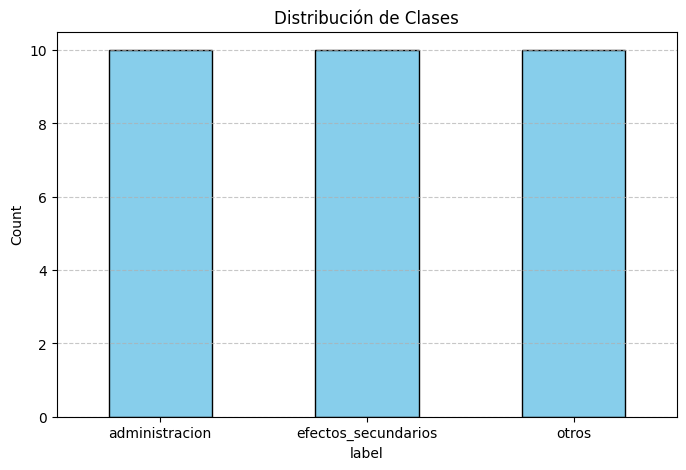


Descripción de duraciones (s):
 count    30.0
mean      5.0
std       0.0
min       5.0
25%       5.0
50%       5.0
75%       5.0
max       5.0
Name: duration_s, dtype: float64


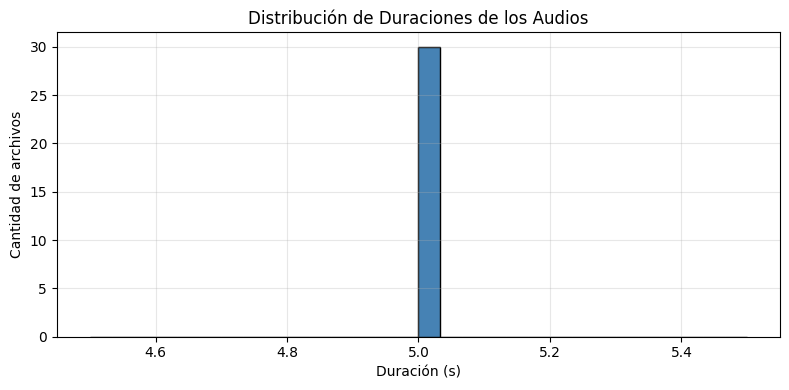


Frecuencia de sample rates originales:
 sr_original
16000    30
Name: count, dtype: int64

Frecuencia de canales:
 channels
1    30
Name: count, dtype: int64


In [47]:
import pandas as pd
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# Asumimos que 'df' ya está definido con columnas 'path' y 'label'

# 1) Recopilar metadata de cada audio
durations = []
samplerates = []
channels = []

for path in df["path"]:
    info = sf.info(path)
    durations.append(info.frames / info.samplerate)
    samplerates.append(info.samplerate)
    channels.append(info.channels)

# Añadimos columnas al DataFrame
df["duration_s"] = durations
df["sr_original"] = samplerates
df["channels"] = channels

# 2) Resumen de la colección
print("Total de archivos:", len(df))

# Contar las ocurrencias de cada clase
class_distribution = df['label'].value_counts()
print("\nArchivos por clase:\n", df["label"].value_counts())

# Crear la gráfica de barras
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribución de Clases')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3) Estadísticas de duración
print("\nDescripción de duraciones (s):\n", df["duration_s"].describe())

# 4) Histograma de duraciones
plt.figure(figsize=(8,4))
plt.hist(df["duration_s"], bins=30, color="steelblue", edgecolor="black")
plt.title("Distribución de Duraciones de los Audios")
plt.xlabel("Duración (s)")
plt.ylabel("Cantidad de archivos")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5) Revisar sample rates y canales
print("\nFrecuencia de sample rates originales:\n", df["sr_original"].value_counts())
print("\nFrecuencia de canales:\n", df["channels"].value_counts())


Reproduciendo audio 1: audio_construccion.wav


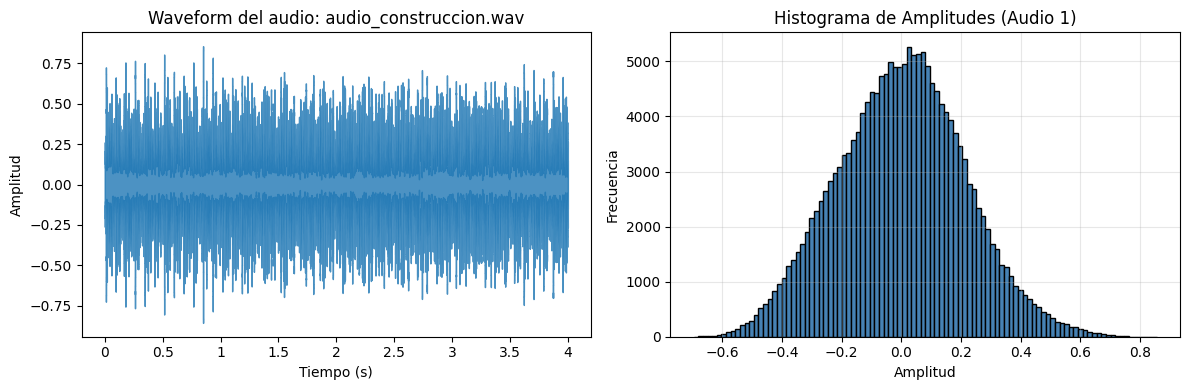

Reproduciendo audio 2: audio_1.wav


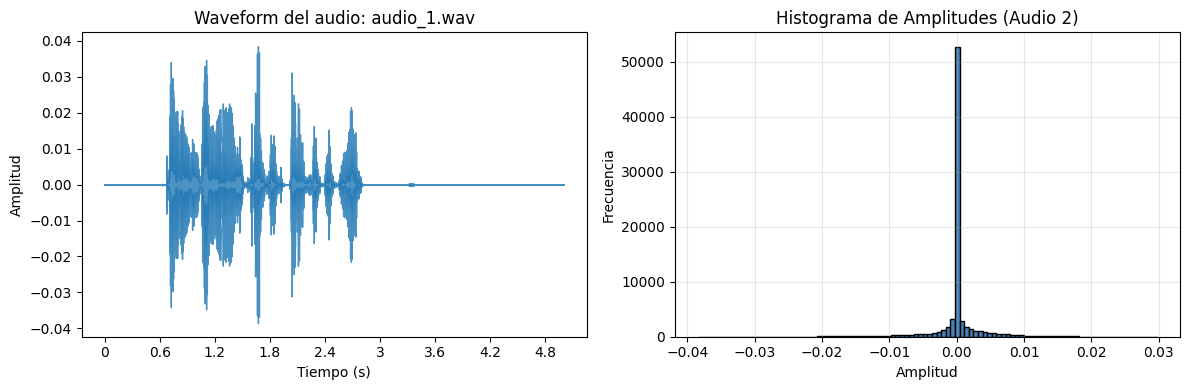

In [52]:
# Ejemplo con el primer audio del DataFrame
path_example_1 = 'audio_construccion.wav'
path_example_2 = df['path'].iloc[0]  # Primer audio del DataFrame

# Cargar ambos audios
y1, sr1 = librosa.load(path_example_1, sr=None, mono=True)
y2, sr2 = librosa.load(path_example_2, sr=None, mono=True)

# Reproducir audio 1
print(f"Reproduciendo audio 1: {os.path.basename(path_example_1)}")
ipd.display(ipd.Audio(y1, rate=sr1))

# Crear figura con 2 subplots para audio 1
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1: Waveform del audio 1
axes[0].set_title(f"Waveform del audio: {os.path.basename(path_example_1)}")
librosa.display.waveshow(y1, sr=sr1, alpha=0.8, ax=axes[0])
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")

# Gráfico 2: Histograma del audio 1
axes[1].set_title("Histograma de Amplitudes (Audio 1)")
axes[1].hist(y1, bins=100, color='steelblue', edgecolor='black')
axes[1].set_xlabel("Amplitud")
axes[1].set_ylabel("Frecuencia")
axes[1].grid(alpha=0.3)

# Ajustar diseño
plt.tight_layout()
plt.show()

# Reproducir audio 2
print(f"Reproduciendo audio 2: {os.path.basename(path_example_2)}")
ipd.display(ipd.Audio(y2, rate=sr2))

# Crear figura con 2 subplots para audio 2
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 3: Waveform del audio 2
axes[0].set_title(f"Waveform del audio: {os.path.basename(path_example_2)}")
librosa.display.waveshow(y2, sr=sr2, alpha=0.8, ax=axes[0])
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")

# Gráfico 4: Histograma del audio 2
axes[1].set_title("Histograma de Amplitudes (Audio 2)")
axes[1].hist(y2, bins=100, color='steelblue', edgecolor='black')
axes[1].set_xlabel("Amplitud")
axes[1].set_ylabel("Frecuencia")
axes[1].grid(alpha=0.3)

# Ajustar diseño
plt.tight_layout()
plt.show()


FALTA HACER AUDIOS CON RUIDO Y SIN RUIDO DICIENDO LO MISMO PARA VER SI PODEMOS ELIMINAR AL MÁXIMO EL RUIDO

#### **PREPROCESADO COMPLETO: Limpieza de ruido, silencio, pre-énfasis**

In [53]:
import numpy as np
import librosa
import librosa.display
from scipy.signal import butter, filtfilt
try:
    import noisereduce as nr
    _HAS_NOISEREDUCE = True
except ImportError:
    _HAS_NOISEREDUCE = False


def butter_bandpass(lowcut: float, highcut: float, fs: int, order: int = 4):
    """
    Diseña un filtro Butterworth pasa-banda.

    Parámetros:
    - lowcut: frecuencia de corte baja en Hz.
    - highcut: frecuencia de corte alta en Hz.
    - fs: frecuencia de muestreo en Hz.
    - order: orden del filtro (defecto=4).

    Retorna:
    - b, a: coeficientes del filtro.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def bandpass_filter(y: np.ndarray, sr: int,
                    lowcut: float = 300.0,
                    highcut: float = 3400.0,
                    order: int = 4) -> np.ndarray:
    """
    Aplica un filtro pasa-banda para conservar sólo la banda de voz.

    Parámetros:
    - y: señal de audio (1D numpy array).
    - sr: frecuencia de muestreo en Hz.
    - lowcut, highcut: límites de frecuencia en Hz.
    - order: orden del filtro.

    Retorna:
    - Señal filtrada.
    """
    b, a = butter_bandpass(lowcut, highcut, sr, order)
    return filtfilt(b, a, y)


def pre_emphasis(y: np.ndarray, coef: float = 0.97) -> np.ndarray:
    """
    Aplica filtro de pre-énfasis para realzar frecuencias altas.

    Fórmula:
        y[n] = x[n] - coef * x[n-1]

    Parámetros:
    - y: señal mono (1D numpy array).
    - coef: coeficiente de pre-énfasis (defecto=0.97).

    Retorna:
    - Señal con pre-énfasis aplicada.
    """
    return np.append(y[0], y[1:] - coef * y[:-1])


def normalize_peak(y: np.ndarray) -> np.ndarray:
    """
    Normalización por pico: escala la señal para que su amplitud máxima sea 1.

    Parámetros:
    - y: señal de audio.

    Retorna:
    - Señal normalizada.
    """
    peak = np.max(np.abs(y))
    return y / peak if peak > 0 else y


def normalize_rms(y: np.ndarray, target_rms: float = 0.1) -> np.ndarray:
    """
    Normalización RMS: ajusta la señal para que su RMS coincida con target_rms.

    Parámetros:
    - y: señal de audio.
    - target_rms: RMS objetivo (defecto=0.1).

    Retorna:
    - Señal normalizada.
    """
    rms = np.sqrt(np.mean(y**2))
    return y * (target_rms / rms) if rms > 0 else y


def frame_signal(y: np.ndarray, sr: int,
                 frame_length: int = None,
                 hop_length: int = None) -> np.ndarray:
    """
    Divide la señal en frames de tamaño fijo.

    Parámetros:
    - y: señal de audio.
    - sr: frecuencia de muestreo.
    - frame_length: tamaño del frame en muestras (defecto 25 ms).
    - hop_length: salto entre frames en muestras (defecto 10 ms).

    Retorna:
    - Matriz de shape (n_frames, frame_length).
    """
    if frame_length is None:
        frame_length = int(0.025 * sr)
    if hop_length is None:
        hop_length = int(0.010 * sr)
    num_frames = 1 + (len(y) - frame_length) // hop_length
    frames = np.lib.stride_tricks.as_strided(
        y,
        shape=(num_frames, frame_length),
        strides=(y.strides[0] * hop_length, y.strides[0])
    )
    return frames


def apply_window(frames: np.ndarray, window_fn=np.hamming) -> np.ndarray:
    """
    Aplica ventana de suavizado a cada frame para reducir leakage.

    Parámetros:
    - frames: matriz (n_frames, frame_length).
    - window_fn: función de ventana (defecto np.hamming).

    Retorna:
    - Frames aplicando la ventana.
    """
    win = window_fn(frames.shape[1])
    return frames * win[None, :]


def reduce_noise(y: np.ndarray, sr: int, prop_decrease: float = 1.0) -> np.ndarray:
    """
    Realiza reducción de ruido por spectral gating usando noisereduce.

    Parámetros:
    - y: señal de audio.
    - sr: frecuencia de muestreo.
    - prop_decrease: proporción de reducción (0 a 1).

    Retorna:
    - Señal con ruido reducido.

    Nota: requiere instalar noisereduce (pip install noisereduce).
    """
    if not _HAS_NOISEREDUCE:
        raise ImportError("Para usar reduce_noise instala la librería noisereduce.")
    return nr.reduce_noise(y=y, sr=sr, prop_decrease=prop_decrease)


def preprocess_audio(path: str,
                     sr: int = 16000,
                     trim_db: float = 20.0,
                     lowcut: float = 300.0,
                     highcut: float = 3400.0,
                     pre_coef: float = 0.97,
                     rms_target: float = 0.1,
                     reduce_noise_flag: bool = False) -> np.ndarray:
    """
    Pipeline completo de preprocesado de audio:
    1) Carga y conversión a mono.
    2) (Opcional) Reducción de ruido.
    3) Recorte de silencio inicial y final.
    4) Pre-énfasis.
    5) Filtro pasa-banda para voz.
    6) Normalización por RMS.

    Parámetros:
    - path: ruta al archivo de audio.
    - sr: frecuencia de muestreo deseada.
    - trim_db: umbral dB para recorte de silencio.
    - lowcut, highcut: límites de frecuencia para filtrado.
    - pre_coef: coeficiente de pre-énfasis.
    - rms_target: RMS objetivo para normalización.
    - reduce_noise_flag: activar reducción de ruido.

    Retorna:
    - Señal procesada lista para extracción de features.
    """
    # 1) Carga
    y, _ = librosa.load(path, sr=sr, mono=True)

    # 2) Reducción de ruido si se solicita
    if reduce_noise_flag:
        y = reduce_noise(y, sr)

    # 3) Recorte de silencio
    y, _ = librosa.effects.trim(y, top_db=trim_db)

    # 4) Pre-énfasis
    y = pre_emphasis(y, coef=pre_coef)

    # 5) Filtrado pasa-banda
    y = bandpass_filter(y, sr, lowcut, highcut)

    # 6) Normalización RMS
    y = normalize_rms(y, target_rms=rms_target)

    return y

In [63]:
# Ejemplo de uso de preprocesado de audio
y_preprocesado = preprocess_audio('audio\\audio_1.wav')

# Reproducir audio preprocesado
import librosa.display
import IPython.display as ipd
ipd.Audio(y_preprocesado, rate=16000)


#### **Visualización del audio**

Playing audio for class: administracion


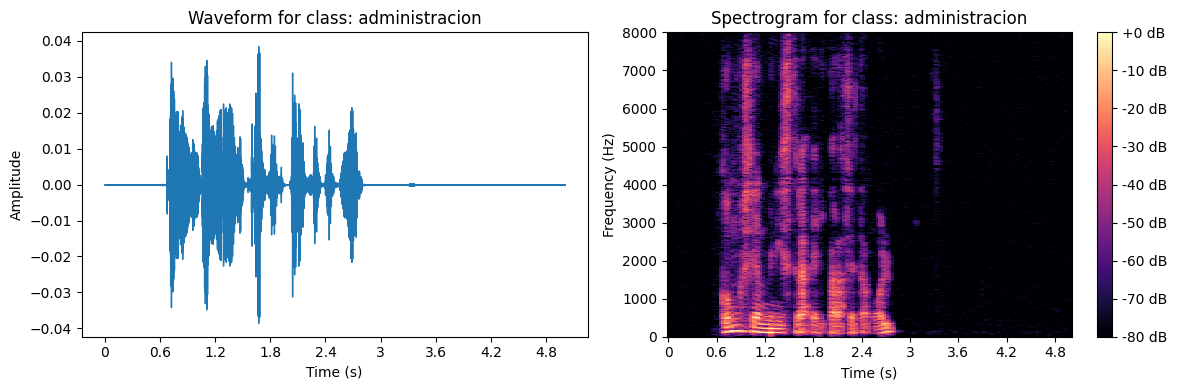

Playing audio for class: efectos_secundarios


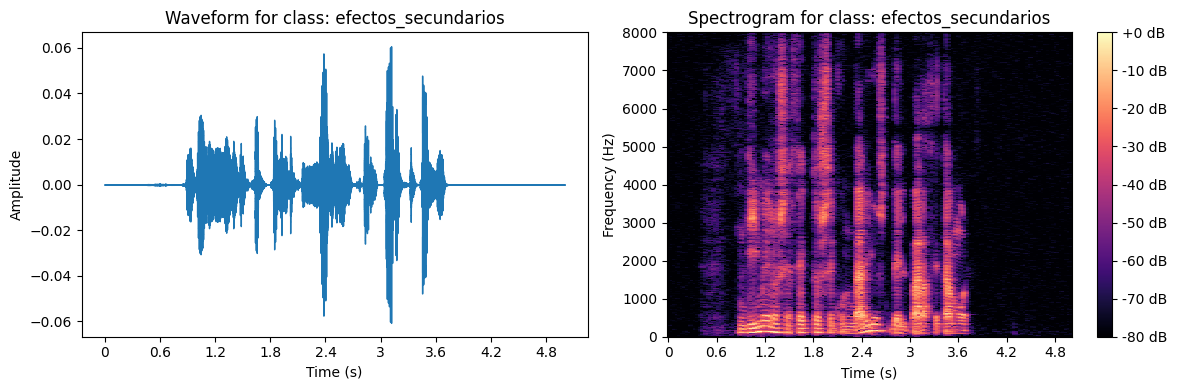

Playing audio for class: otros


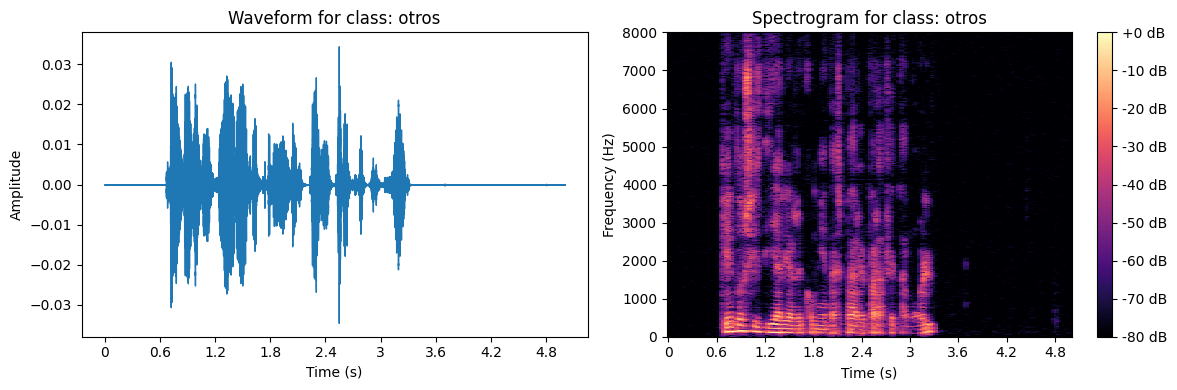

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

# Get one sample per class
sample_per_class = df.groupby("label").first().reset_index()

for _, row in sample_per_class.iterrows():
    filename = row["path"]
    label = row["label"]
    
    # Load audio file
    data, sample_rate = librosa.load(filename, sr=None)
    
    # Plot waveform and spectrogram side by side
    print(f"Playing audio for class: {label}")
    ipd.display(ipd.Audio(filename))
    
    plt.figure(figsize=(12, 4))
    
    # Plot waveform on the left
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(data, sr=sample_rate)
    plt.title(f"Waveform for class: {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    # Plot spectrogram on the right
    plt.subplot(1, 2, 2)
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram for class: {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    
    plt.tight_layout()
    plt.show()

#### **Distribución de clases**

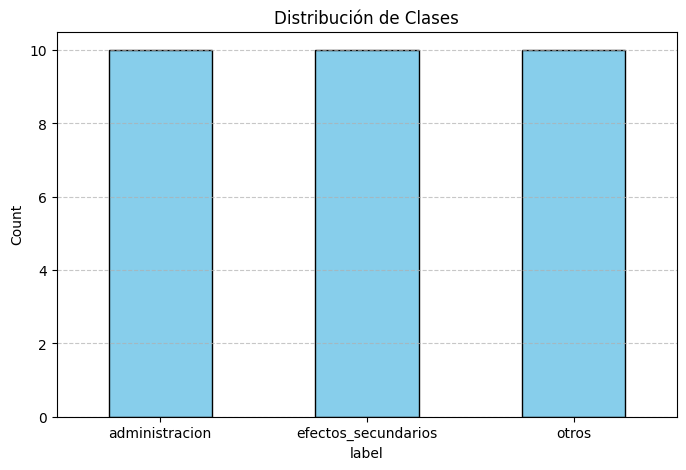

In [10]:
import matplotlib.pyplot as plt

# Contar las ocurrencias de cada clase
class_distribution = df['label'].value_counts()

# Crear la gráfica de barras
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribución de Clases')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### **Quitar silencio de los audios** (ya lo hacemos en la limpieza de ruido)

In [ ]:
import librosa
import numpy as np

def remove_silence(y: np.ndarray,
                   top_db: float = 20.0):
    """
    Elimina los silencios al inicio y al final de una señal de audio.

    Parámetros:
    - y: señal de audio (array 1D).
    - sr: sample rate de la señal (e.g. 16000).
    - top_db: umbral en dB para considerar silencio (por defecto 20 dB).

    Retorna:
    - y_trimmed: señal recortada sin silencios en extremos.
    """
    # librosa.effects.trim detecta y elimina silencios en la señal
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    return y_trimmed

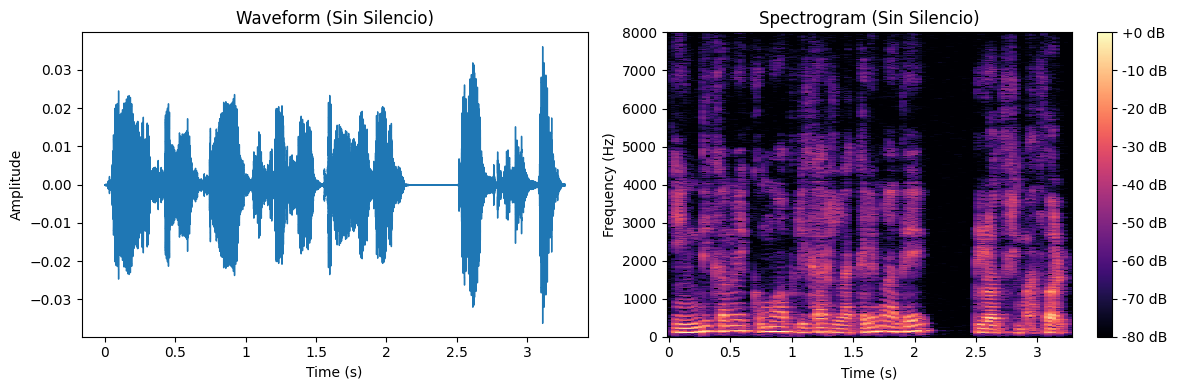

In [ ]:
# Cargamos audio
y, sr = librosa.load("data\outputs\\6_audios\\administracion\\audio_3.wav", sr=16000, mono=True)

# Elimina silencios inicial/final
y_silence = remove_silence(y, top_db=20.0)

# Escuchar audio sin silencio
ipd.display(ipd.Audio(y_silence, rate=sr))
plt.figure(figsize=(12, 4))

# Plot waveform
plt.subplot(1, 2, 1)
librosa.display.waveshow(y_silence, sr=sr)
plt.title("Waveform (Sin Silencio)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot spectrogram
plt.subplot(1, 2, 2)
spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(y_silence)), ref=np.max)
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Sin Silencio)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

#### **Zero Crossing**

In [23]:
def plot_zero_crossing(y: np.ndarray,
                       sr: int,
                       frame_length: int = 2048,
                       hop_length: int = 512):
    """
    Calcula la tasa de cruces por cero y muestra una gráfica de ZCR vs tiempo.

    Parámetros:
    - y: señal de audio (1D numpy array).
    - sr: sample rate de la señal (e.g., 16000).
    - frame_length: tamaño de la ventana en muestras (por defecto 2048).
    - hop_length: salto entre ventanas en muestras (por defecto 512).
    """
    # 1) Calcula ZCR por frame
    zcr = librosa.feature.zero_crossing_rate(
        y, frame_length=frame_length, hop_length=hop_length
    )[0]
    
    # 2) Convierte índices de frames a tiempo (segundos)
    times = librosa.frames_to_time(np.arange(len(zcr)), sr=sr, hop_length=hop_length)
    
    # 3) Graficar
    plt.figure(figsize=(10, 4))
    plt.plot(times, zcr, label="ZCR")
    plt.title("Zero Crossing Rate a lo largo del tiempo")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Tasa de Cruces por Cero")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return zcr

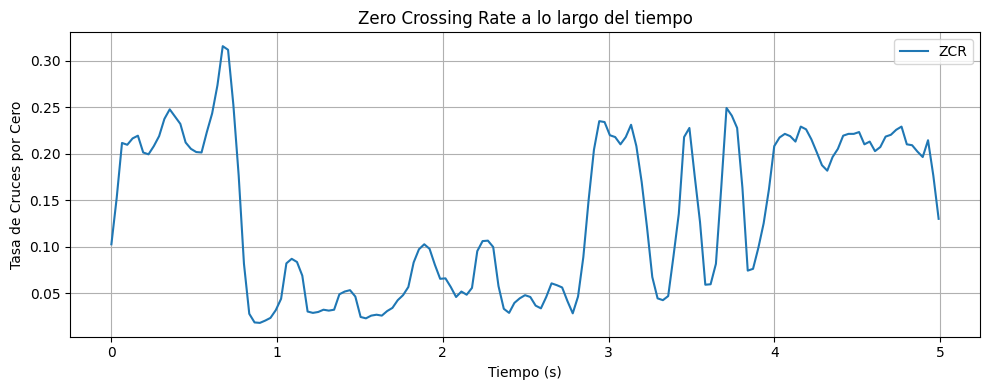

In [24]:
# Cargamos audio
y, sr = librosa.load("data\outputs\\6_audios\\administracion\\audio_3.wav", sr=16000, mono=True)

# Zero Crossing Rate
zcr = plot_zero_crossing(y, sr)

El Zero Crossing Rate (ZCR) mide la frecuencia con la que la señal de audio cambia de signo (de positivo a negativo o viceversa) por unidad de tiempo. En otras palabras, cuenta cuántas veces cruza el valor cero en cada frame de la señal.

¿Qué significa y qué hace?

Matemáticamente, si 
𝑦
[
𝑛
]
y[n] es la amplitud de la señal en la muestra 
𝑛
n, el ZCR por frame es

Z
C
R
=
1
2
𝑁
∑
𝑛
=
1
𝑁
∣
sgn
⁡
(
𝑦
[
𝑛
]
)
−
sgn
⁡
(
𝑦
[
𝑛
−
1
]
)
∣
,
ZCR= 
2N
1
​
  
n=1
∑
N
​
  
​
 sgn(y[n])−sgn(y[n−1]) 
​
 ,
donde 
sgn
⁡
(
⋅
)
sgn(⋅) es la función signo y 
𝑁
N el número de muestras del frame ​[AUDIO] Unstructured Da….

¿Para qué sirve?

Diferenciar tipos de sonido

Las señales muy percutivas (golpes, tambores, sonidos metálicos) tienen ZCR elevado, mientras que sonidos más tonales (voces, cuerdas) lo tienen bajo ​[AUDIO] Unstructured Da….

Detección de voz vs. silencio o ruido

En Voice Activity Detection, ayuda a identificar segmentos de habla (ZCR moderado/bajo) frente a segmentos de ruido blanco (ZCR alto) o silencio (ZCR casi cero).

Segmentación y onset detection

Detección de inicios de notas o eventos sonoros: un pico en ZCR suele coincidir con un cambio brusco en la señal.

Caracterización de contenido

Como feature en tareas de clasificación de audio (género musical, reconocimiento de emociones, clasificación de efectos adversos en tu caso), aporta información sobre la “agresividad” o “textura” del sonido.

En resumen, el Zero Crossing Rate es una medida sencilla pero muy útil para captar la naturaleza temporal y el grado de percutividad de una señal, sirviendo de base en multitud de sistemas de análisis y clasificación de audio ​

Este patrón de ZCR es muy característico de una señal de voz humana en la que se alternan sonidos voiced (vocales) y unvoiced (consonantes “ruidosas”).

ZCR bajo (≈ 0.02–0.06)
Corresponde a segmentos con vocales o sonidos sonoros (por ejemplo /a/, /e/, /i/), donde la onda es más suave y mantiene un mismo signo durante más tiempo ​[AUDIO] Unstructured Da….

ZCR alto (≈ 0.2–0.3)
Coincide con consonantes sin voz como fricativas (/s/, /f/) o estallidos (/p/, /t/) y con ruido de fondo. En estos sonidos la señal oscila muy rápidamente alrededor de cero, produciendo muchos cruces ​[AUDIO] Unstructured Da….

En tu caso, verías picos de ZCR cada vez que pronuncias un fonema “ruidoso” (por ejemplo la “s” de “secundarios” o la “p” de “paracetamol”), y valles durante las vocales o pausas. Esto te permite, por ejemplo, segmentar automáticamente dónde empiezan y acaban los fonemas consonánticos más percutivos frente a las vocales, o diferenciar voz de ruido.

In [27]:
import numpy as np

# zcr es el array de tasas por frame que calculamos antes
var_zcr = np.var(zcr)
# rms por frame
import librosa
rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
var_rms = np.var(rms)

# Si ambas varianzas son muy bajas => señal homogénea (música/ambiente)
print(f"Varianza ZCR: {var_zcr:.8f}, Varianza RMS: {var_rms:.8f}")

Varianza ZCR: 0.00685168, Varianza RMS: 0.00001113


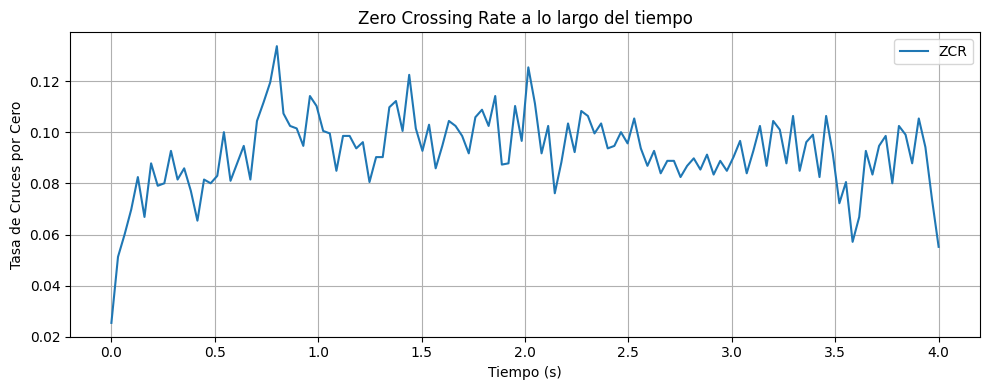

In [21]:
# Cargamos audio
y, sr = librosa.load("audio_construccion.wav", sr=16000, mono=True)

# Zero Crossing Rate
plot_zero_crossing(y, sr)

In [ ]:
import numpy as np

# zcr es el array de tasas por frame que calculamos antes
var_zcr = np.var(zcr)
# rms por frame
import librosa
rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
var_rms = np.var(rms)

# Si ambas varianzas son muy bajas => señal homogénea (música/ambiente)


#### **Spectral centroid y Spectral Rollrof**

In [43]:
import numpy as np
# Parche para compatibilidad librosa/numpy
np.complex = complex

import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing

def plot_spectral_centroid_same_scale(y: np.ndarray, sr: int):
    """
    Plotea el waveform normalizado y el Spectral Centroid normalizado,
    ambos en la misma escala [0, 1].

    - Waveform: normalizado min-max.
    - Spectral Centroid: normalizado min-max.
    """
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # Computing the time variable for visualization
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)

    # Normalising function for visualisation
    def normalize(y, axis=0):
        return preprocessing.minmax_scale(y, axis=axis)

    #Plotting the Spectral Centroid along the waveform
    librosa.display.waveshow(y, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.grid()
    plt.show()


def plot_spectral_rolloff_same_scale(y: np.ndarray, sr: int, roll_percent: float = 0.85):
    """
    Plotea el waveform normalizado y el Spectral Rolloff normalizado,
    ambos en la misma escala [0, 1].

    - Waveform: normalizado min-max.
    - Spectral Rolloff: normalizado min-max.
    """
    # Normalising the spectral centroid for visualisation
    def normalize(x, axis=0):
        return sklearn.preprocessing.minmax_scale(x, axis=axis)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y + 0.01, sr=sr)[0] # - y=y+0.01: Se añade 0.01 a la señal para evitar problemas numéricos (por ejemplo, evitar dividir entre cero).
    t = librosa.frames_to_time(range(len(spectral_rolloff)), sr=sr)
    librosa.display.waveshow(y, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.grid()


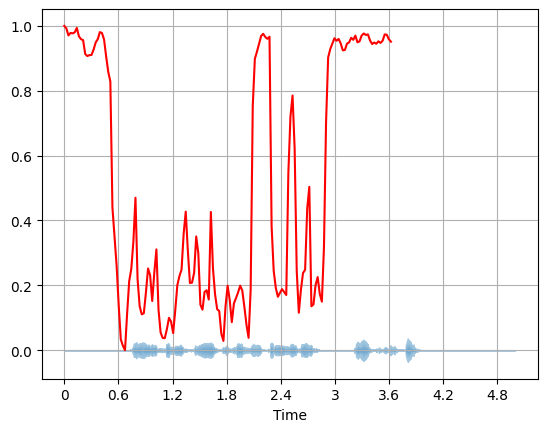

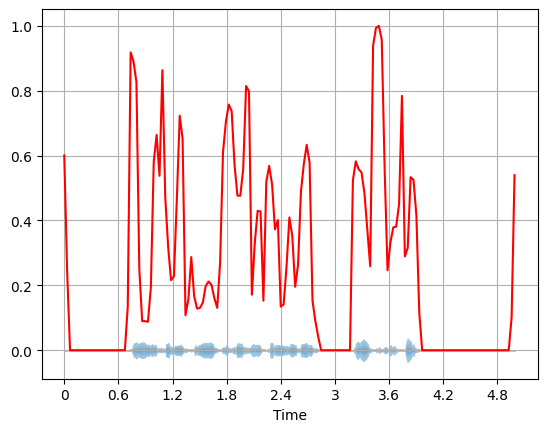

In [44]:
# Ejemplo de uso:
# Cargamos audio
y, sr = librosa.load("data\outputs\\6_audios\\administracion\\audio_3.wav", sr=16000, mono=True)
plot_spectral_centroid_same_scale(y, sr)
plot_spectral_rolloff_same_scale(y, sr)


In [1]:
import librosa
import numpy as np

def extract_features(path, sr=16000, n_mfcc=13):
    # 1) cargar audio
    y, _ = librosa.load(path, sr=sr, mono=True)
    # 2) recortar silencios al inicio/final
    y, _ = librosa.effects.trim(y)
    # 3) pre-énfasis
    y = np.append(y[0], y[1:] - 0.97 * y[:-1])
    # 4) extraer MFCCs — aquí sólo con keyword args
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # 5) devolver resumen: media y varianza de cada coeficiente
    return np.hstack([mfccs.mean(axis=1), mfccs.var(axis=1)])


In [9]:
features = []
for _, row in df.iterrows():
    vec = extract_features(row["path"])
    features.append(vec)
X = np.vstack(features)
y = df["label"].values


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)


In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                     precision    recall  f1-score   support

     administracion       1.00      1.00      1.00         1
efectos_secundarios       0.67      1.00      0.80         2
              otros       1.00      0.50      0.67         2

           accuracy                           0.80         5
          macro avg       0.89      0.83      0.82         5
       weighted avg       0.87      0.80      0.79         5

[[1 0 0]
 [0 2 0]
 [0 1 1]]
